# Пакети/модулі та їх опції

In [2]:
import keras
from keras.callbacks import ModelCheckpoint
from keras import layers
from keras.models import Sequential
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import time

%matplotlib inline

# Константи

In [3]:
IMG_ROWS, IMG_COLS = 28, 28
RANDOM_STATE = int(time.time()) - 23-10-2023
EPOCHS_AMO, BATCH_SIZE = 33, 64
VALID_SIZE = 0.2
SAVED_BEST_MODEL = "best_cnn_model.hdf5"
CLASS_NAMES = ['Футболка', 'Брюки', 'Пуловер', 'Плаття', 'Пальто',
               'Босоніжка','Сорочка', 'Кросівка', 'Сумка', 'Черевик']
BAD_TEST_CASES=[1662,2311,2478,2659,3327,3918,5520,5037,6024,7024,7369,7800,8465,8804,9590]

# Дейтасет

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print("Amount images in training set {}".format(x_train.shape))
print("Amount labels in training set {}".format(y_train.shape))
print("Amount images in test set {}".format(x_test.shape))
print("Amount labels in test set {}".format(y_train.shape))

Amount images in training set (60000, 28, 28)
Amount labels in training set (60000,)
Amount images in test set (10000, 28, 28)
Amount labels in test set (60000,)


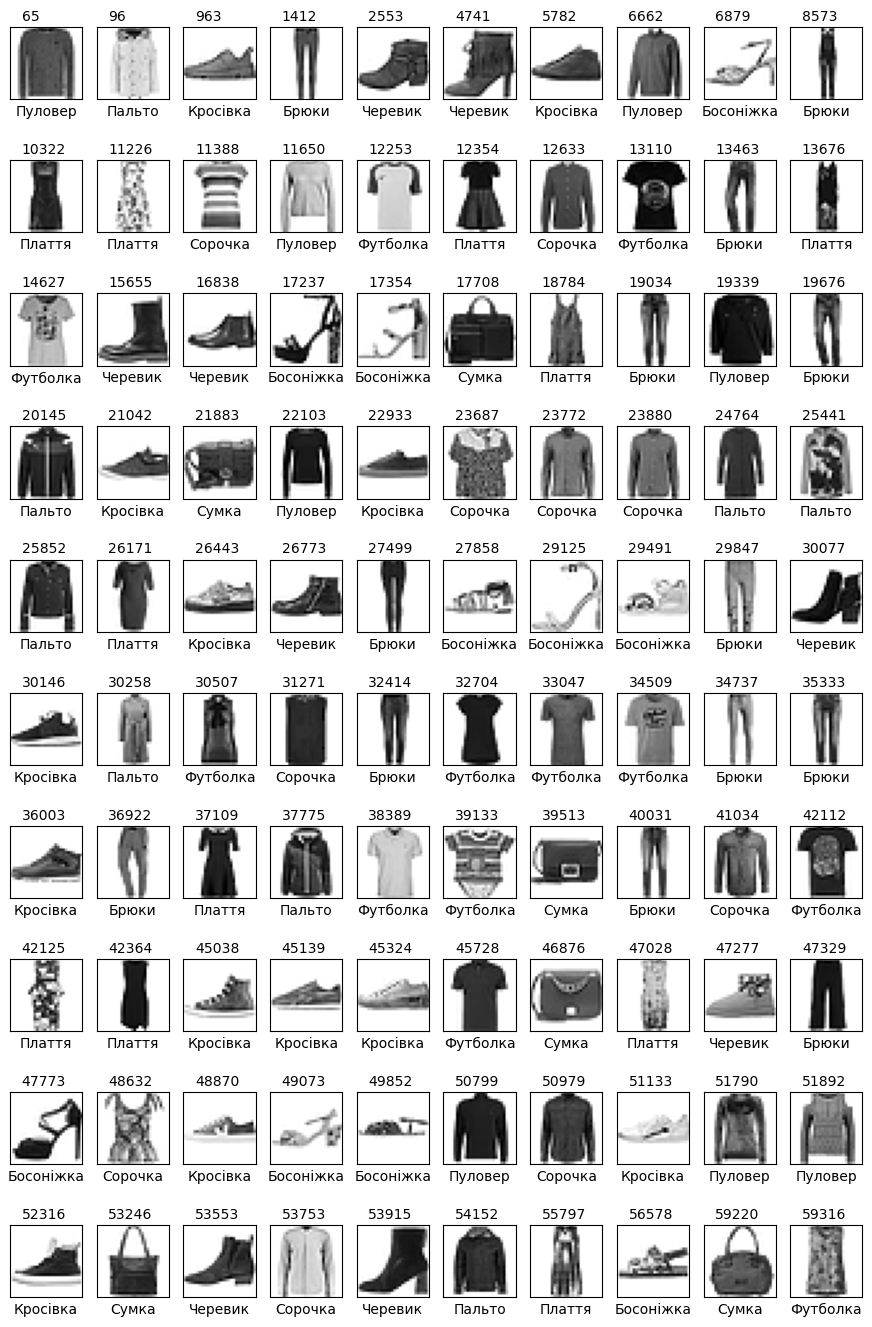

In [5]:
plt.figure(figsize=(11,17))
i = 0
for ind in np.sort(np.random.randint(0, x_train.shape[0], size=100, dtype=int)):
    i += 1
    plt.subplot(10,10,i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[ind], cmap='binary')
    plt.xlabel(CLASS_NAMES[y_train[ind]])
    plt.text(x=4, y=-3, s=ind)
plt.show()

# Створення CNN

## Підготовка даних

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Виділяється частка для валідації
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=VALID_SIZE,
                                                      random_state=RANDOM_STATE)

# x_train = np.concatenate((x_train, x_test[BAD_TEST_CASES]))
# y_train = np.concatenate((y_train, y_test[BAD_TEST_CASES]))

# Додається додатковий вимір
x_train = x_train.reshape(x_train.shape[0], IMG_ROWS, IMG_COLS, 1)
x_valid = x_valid.reshape(x_valid.shape[0], IMG_ROWS, IMG_COLS, 1)
x_test = x_test.reshape(x_test.shape[0], IMG_ROWS, IMG_COLS, 1)

# Зображення нормалізуються так, щоб піксели були масштабно відображені в діапазоні [0,1]
(x_train, x_valid, x_test) = (tf.cast(x_train/255.0, tf.float32),
                              tf.cast(x_valid/255.0, tf.float32),
                              tf.cast(x_test/255.0, tf.float32))

# Розмітки даних треба "категорізувати"
y_train = keras.utils.to_categorical(y_train)
y_valid = keras.utils.to_categorical(y_valid)
y_test = keras.utils.to_categorical(y_test)

print(x_train.shape, x_valid.shape, x_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

2023-10-30 15:50:31.138538: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


(48000, 28, 28, 1) (12000, 28, 28, 1) (10000, 28, 28, 1)
(48000, 10) (12000, 10) (10000, 10)


## Модель 1

In [7]:
# Seems it is the best variant from many other attempts
model = Sequential()
model.add(layers.Conv2D(filters=127, kernel_size=2, padding='same',
                        activation='relu', input_shape=(IMG_ROWS,IMG_COLS,1)))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.3))
# model.add(layers.Conv2D(filters=63, kernel_size=2, padding='same', activation='relu'))
# model.add(layers.MaxPooling2D(pool_size=2))
# model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=31, kernel_size=2, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(CLASS_NAMES), activation='softmax'))

# SGD/20      val_loss: 0.3043 - val_accuracy: 0.8928
# Nadam/8     val_loss: 0.2514 - val_accuracy: 0.9133
# Adamax/15   val_loss: 0.2522 - val_accuracy: 0.9116
# RMSprop/5   val_loss: 0.2360 - val_accuracy: 0.9175
# Adadelta/20 val_loss: 0.3729 - val_accuracy: 0.9226 ???
# Adagrad/20  val_loss: 0.3956 - val_accuracy: 0.8668
# FTRL/1      val_loss: 2.3026 - val_accuracy: 0.0960
# model = Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform',
#                         input_shape=(IMG_ROWS,IMG_COLS,1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
# model.add(layers.Dense(len(CLASS_NAMES), activation='softmax'))

In [8]:
model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 127)       635       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 127)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 127)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 31)        15779     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 31)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 31)          0

In [9]:
checkpointer = ModelCheckpoint(filepath=SAVED_BEST_MODEL, verbose=1, save_best_only=True)
model.fit(x_train,
         y_train,
          
         batch_size=BATCH_SIZE,
         epochs=EPOCHS_AMO,
         validation_data=(x_valid, y_valid),
         callbacks=[checkpointer])

Epoch 1/33
750/750 [==============================] - ETA: 0s - loss: 0.6157 - accuracy: 0.7718
Epoch 1: val_loss improved from inf to 0.38771, saving model to best_cnn_model.hdf5
750/750 [==============================] - 162s 213ms/step - loss: 0.6157 - accuracy: 0.7718 - val_loss: 0.3877 - val_accuracy: 0.8660
Epoch 2/33
750/750 [==============================] - ETA: 0s - loss: 0.4129 - accuracy: 0.8512
Epoch 2: val_loss improved from 0.38771 to 0.33583, saving model to best_cnn_model.hdf5
750/750 [==============================] - 189s 252ms/step - loss: 0.4129 - accuracy: 0.8512 - val_loss: 0.3358 - val_accuracy: 0.8796
Epoch 3/33
750/750 [==============================] - ETA: 0s - loss: 0.3691 - accuracy: 0.8670
Epoch 3: val_loss improved from 0.33583 to 0.30666, saving model to best_cnn_model.hdf5
750/750 [==============================] - 195s 260ms/step - loss: 0.3691 - accuracy: 0.8670 - val_loss: 0.3067 - val_accuracy: 0.8895
Epoch 4/33
750/750 [===========================

Epoch 28/33
750/750 [==============================] - ETA: 0s - loss: 0.1944 - accuracy: 0.9254
Epoch 28: val_loss did not improve from 0.21139
750/750 [==============================] - 222s 296ms/step - loss: 0.1944 - accuracy: 0.9254 - val_loss: 0.2146 - val_accuracy: 0.9255
Epoch 29/33
750/750 [==============================] - ETA: 0s - loss: 0.1905 - accuracy: 0.9277
Epoch 29: val_loss did not improve from 0.21139
750/750 [==============================] - 219s 292ms/step - loss: 0.1905 - accuracy: 0.9277 - val_loss: 0.2162 - val_accuracy: 0.9236
Epoch 30/33
750/750 [==============================] - ETA: 0s - loss: 0.1877 - accuracy: 0.9281
Epoch 30: val_loss did not improve from 0.21139
750/750 [==============================] - 218s 291ms/step - loss: 0.1877 - accuracy: 0.9281 - val_loss: 0.2139 - val_accuracy: 0.9245
Epoch 31/33
750/750 [==============================] - ETA: 0s - loss: 0.1870 - accuracy: 0.9282
Epoch 31: val_loss did not improve from 0.21139
750/750 [======

In [10]:
model.load_weights(SAVED_BEST_MODEL)

In [11]:
score = model.evaluate(x_train, y_train)
print(f'[*] Test accuracy with TRAIN images: {round(score[1]*100, 2)}%')

1500/1500 [==============================] - 66s 44ms/step - loss: 0.1162 - accuracy: 0.9600
[*] Test accuracy with TRAIN images: 96.0%


In [13]:
score = model.evaluate(x_test, y_test)
print(f'[*] Test accuracy with TEST images: {round(score[1]*100, 0)}%')

313/313 [==============================] - 13s 41ms/step - loss: 0.2269 - accuracy: 0.9162
[*] Test accuracy with TEST images: 92.0%


In [14]:
probability_model = tf.keras.Sequential([model,  tf.keras.layers.Softmax()])
predictions = probability_model.predict(x_test)

313/313 [==============================] - 11s 33ms/step


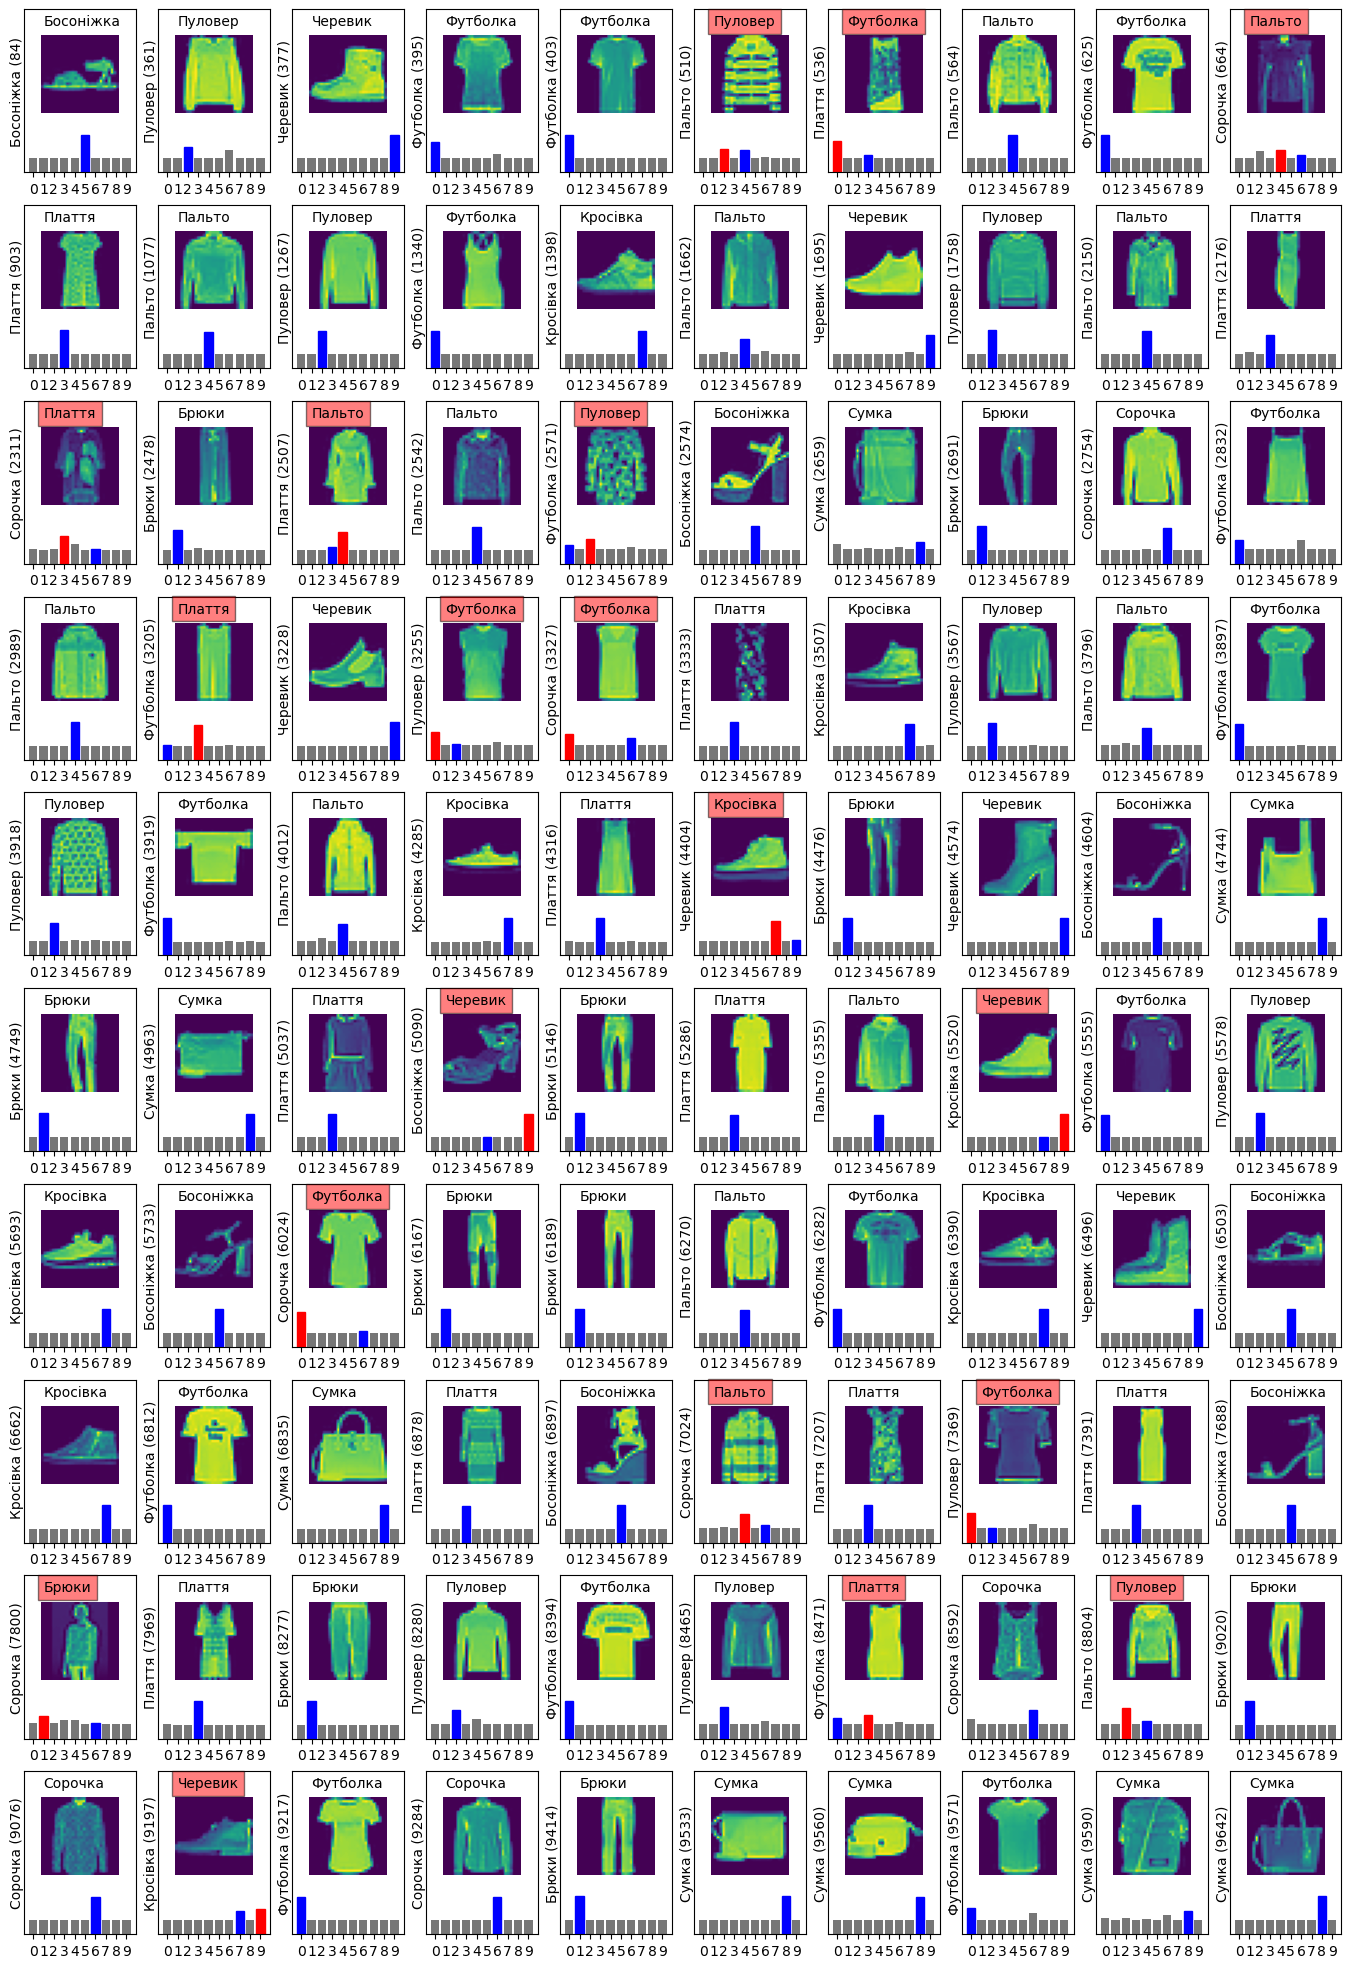

In [15]:
def indices(arr, size, sizemax):
    assert size <= sizemax
    rest = size - len(arr)
    if rest <= 0:
        return np.array(arr[:size])
    arr = np.unique(np.concatenate((np.array(arr),
                                    np.random.randint(0, sizemax, size=rest, dtype=int))))
    while len(arr) < size:
        arr = np.unique(np.concatenate((arr,
                                        np.random.randint(0, sizemax, size=size-len(arr), dtype=int))))
    return arr

plt.figure(figsize=(17,25))
i = 0
for ind in indices(BAD_TEST_CASES, 100, y_test.shape[0]):
    y_predict_ind = np.argmax(predictions[ind])
    y_predict = CLASS_NAMES[y_predict_ind]
    y_actual_ind = np.argmax(y_test[ind])
    y_actual = CLASS_NAMES[y_actual_ind]
    bbox = None
    if y_actual_ind != y_predict_ind:
        bbox = dict(facecolor='red', alpha=0.5)
    img = x_test[ind]
    # Show image and bars of classification
    i += 1
    fig = plt.subplot(10,10,i)
    imagebox = OffsetImage(img, zoom = 2)
    fig.axes.add_artist(AnnotationBbox(imagebox, (4.5,0.6), frameon = False))
    plt.grid(False)
    plt.xticks(range(len(CLASS_NAMES)))
    plt.yticks([])
    thisplot = plt.bar(range(len(CLASS_NAMES)), predictions[ind], color="#777777", alpha=1)
    plt.ylim([0, 1])
    plt.ylabel(f"{y_actual} ({ind})", labelpad=0)
    thisplot[y_predict_ind].set_color('red')
    thisplot[y_actual_ind].set_color('blue')
    plt.text(x=1, y=0.9, s=y_predict, bbox=bbox)

plt.show()